# Evaluate validation

This script evaluates the performance of LLM-generated vital sign extraction 
from clinical notes using structured validation data.

It supports:
------------
1. Precision, Recall, F1 Evaluation
   - Compares predicted outputs against manually annotated ground truth.
   - Validates JSON structure and tracks both content and format errors.
   - Plots for precision/recall/F1 per model and prompt.

2. Support for simple JSON and FLAT JSON Formats
   - Dynamically switches ground truth JSON file based on prompt ID.
   - Evaluates models producing simple vs openEHR-style outputs.

3. Batch Size Analysis
   - Compare how different batch sizes impact performance, emissions and inference time.

Main Functions:
---------------
- `load_model_output`: Load the desired outputs
- `flatten_extracted_data`: Flat json field to make comparison easier
- `is_valid_structure`: Check structure validity
- `evaluate(...)`: Compute evaluation metrics
- `evaluate_and_collect(...)`: Loads outputs, evaluates, collects emissions and plots results
- `plot_results(...)`: Plote models results

In [2]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
import json

In [3]:
def load_model_output(jsonl_file):
    results = {}
    with open(jsonl_file, 'r') as reader:
        for line in reader:
            obj = json.loads(line)
            note_id = obj.get("note_number")
            if note_id:
                results[note_id] = obj
    return results

def flatten_extracted_data(data):
    flat = {}
    if not isinstance(data, dict):
        return flat
    for section, values in data.items():
        if isinstance(values, dict):
            flat.update({f"{section}|{key}": val for key, val in values.items()})
    return flat

In [4]:
# === Check structure validity ===
subfields = [
    "Body Temperature", "Systolic Blood Pressure", "Diastolic Blood Pressure",
    "Heart Rate", "Respiratory Rate", "Oxygen Saturation",
    "mimic-iv_to_openehr/vital_signs/body_temperature/any_event:{index}/temperature|magnitude", 
    "mimic-iv_to_openehr/vital_signs/blood_pressure/any_event:{index}/systolic|magnitude",
    "mimic-iv_to_openehr/vital_signs/blood_pressure/any_event:{index}/diastolic|magnitude",
    "mimic-iv_to_openehr/vital_signs/pulse_heart_beat/any_event:{index}/rate|magnitude",
    "mimic-iv_to_openehr/vital_signs/respiration/any_event:{index}/rate|magnitude", 
    "mimic-iv_to_openehr/vital_signs/pulse_oximetry/any_event:{index}/spo|numerator"]

allowed_structure = {"Emergency Department": subfields, "Transfer": subfields, "Admission": subfields, "Discharge": subfields, "Unknown": subfields,}

def is_valid_structure(json_obj):
    if not isinstance(json_obj, dict):
        return None
    for main_key, sub_obj in json_obj.items():
        if main_key not in allowed_structure:
            return False
        if not isinstance(sub_obj, dict):
            return None
        for sub_key in sub_obj:
            if sub_key not in allowed_structure[main_key]:
                return False
    return True

In [5]:
def evaluate(ground_truth, model_results):
    
    TP = FP = FN = 0
    valid_cases  = invalid_cases = wrong_keys_cases = 0

    for entry in ground_truth:
        note = entry['note_number']
        gt_flat = flatten_extracted_data(entry['extracted_data'])

        if note not in model_results:
            invalid_cases += 1
            continue
            
        parsed = model_results.get(note, {}).get("parsed_json", {})
        pred_flat = {}

        expected_field_count = len(gt_flat) 
        if not parsed:
            invalid_cases += 1
            FN += expected_field_count  # Count missed values
            continue
        elif not is_valid_structure(parsed):
            wrong_keys_cases += 1
            pred_flat = flatten_extracted_data(parsed)
        else:
            valid_cases += 1
            pred_flat = flatten_extracted_data(parsed)

        for key, gt_val in gt_flat.items():
            pred_val = pred_flat.get(key, None)
            if pred_val is None:
                FN += 1  # expected but not predicted value
            elif pred_val == gt_val:
                TP += 1  # correct value
            else:
                FP += 1  # incorrect value
    
        for key, val in pred_flat.items():
            if key not in gt_flat and val not in [None, "None", ""]:
                FP += 1  # Count rest of missed values

    # === Metrics ===
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return precision, recall, f1, valid_cases, invalid_cases, wrong_keys_cases

In [6]:
def evaluate_and_collect(prompt, path, flat = False):
    
    # === Load ground truth depending on prompt ===
    if flat:
        gt_path = "datasets/ground_truth_flat.json"
    else:
        gt_path = "datasets/ground_truth.json"

    with open(gt_path, 'r') as f:
        gt = json.load(f)

    # === Load outputs ===
    preds = load_model_output(f"{path}.jsonl")

    # === Evaluate and get results ===
    precision, recall, f1, valid_cases, invalid_cases, wrong_keys_cases = evaluate(gt, preds)
    # print(f"Correct notes: {valid_cases}")
    # print(f"Notes with invalid JSON: {invalid_cases}")
    # print(f"Notes with valid JSON but invalid keys: {wrong_keys_cases}")

    # == Get emissions and duration ===
    df = pd.read_csv("emissions.csv")
    row = df[df["project_name"] == prompt]
    emissions = row.iloc[0]["emissions"] if not row.empty else None
    duration = row.iloc[0]["duration"] if not row.empty else None

    return {
        "prompt": prompt,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "V/I/W": f"{valid_cases}/{invalid_cases}/{wrong_keys_cases}",
        "emissions": emissions,
        "duration": duration
    }

In [7]:
def plot_results(results, model, letter):
    results_df = pd.DataFrame(results)
    pd.set_option('display.width', 200)
    pd.set_option('display.max_columns', None)

    # === Normalize emissions and duration ===
    results_df["emissions"] /= 50
    results_df["duration"] /= 50
    print(results_df)

    # === Extract last character from prompt as the new label ===
    results_df["label"] = results_df["prompt"].str.extract(r'(\d)$')

    # === Split groups ===
    first_group = results_df.iloc[:4].set_index("label")
    second_group = results_df.iloc[4:].set_index("label")

    # === Plot setup ===
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    metric_cols = ["precision", "recall", "f1"]
    markers = ['o', 's', '^']

    for i, group in enumerate([first_group, second_group]):
        ax = axes[i]
        for metric, marker in zip(metric_cols, markers):
            group[metric].plot(marker=marker, ax=ax, label=metric)

        ax.set_ylim(-0.05, 0.85)
        ax.set_yticks([round(x * 0.1, 1) for x in range(9)])
        ax.set_xlabel("Number of Examples")
        ax.set_ylabel("Score" if i == 0 else "")
        ax.set_title("Simple JSON" if i == 0 else "Flat JSON")
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend(title="Metric")
    
    plt.suptitle(f"{letter}) Evaluation Metrics for {model}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

      prompt  precision    recall        f1    V/I/W  emissions   duration
0  llama3_10   0.659236  0.785579  0.716883   45/2/3   0.000037   7.693245
1  llama3_11   0.698234  0.798165  0.744863   47/3/0   0.000033   6.834270
2  llama3_13   0.725962  0.810376  0.765850   47/0/3   0.000036   7.903344
3  llama3_15   0.758741  0.745704  0.752166   44/2/4   0.000037   7.753373
4  llama3_20   0.000000  0.000000  0.000000   1/0/49   0.000093  18.176572
5  llama3_21   0.189015  0.189320  0.189167   3/1/46   0.000099  19.979380
6  llama3_23   0.431405  0.440878  0.436090  20/2/28   0.000102  20.362962
7  llama3_25   0.631783  0.548822  0.587387  23/4/23   0.000105  21.069866


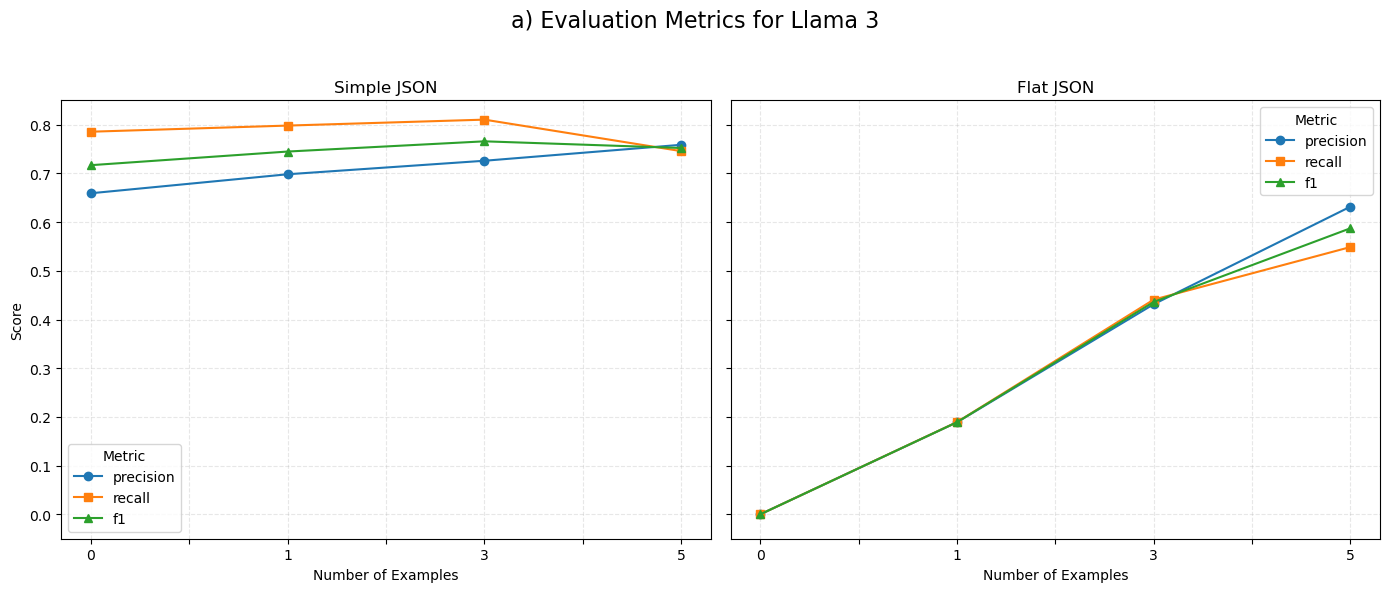

         prompt  precision    recall        f1    V/I/W  emissions   duration
0  meditron3_10   0.382114  0.577869  0.460033  35/4/11   0.000043   8.679868
1  meditron3_11   0.503115  0.672917  0.575758   47/1/2   0.000032   6.697798
2  meditron3_13   0.576329  0.621072  0.597865   45/3/2   0.000031   6.479376
3  meditron3_15   0.611390  0.669725  0.639229   46/2/2   0.000033   6.843991
4  meditron3_20   0.000000  0.000000  0.000000   0/4/46   0.000059  11.529462
5  meditron3_21   0.347573  0.345560  0.346563   37/5/8   0.000086  16.928667
6  meditron3_23   0.558416  0.533081  0.545455   43/3/4   0.000083  16.374587
7  meditron3_25   0.618321  0.576512  0.596685   41/5/4   0.000102  20.431809


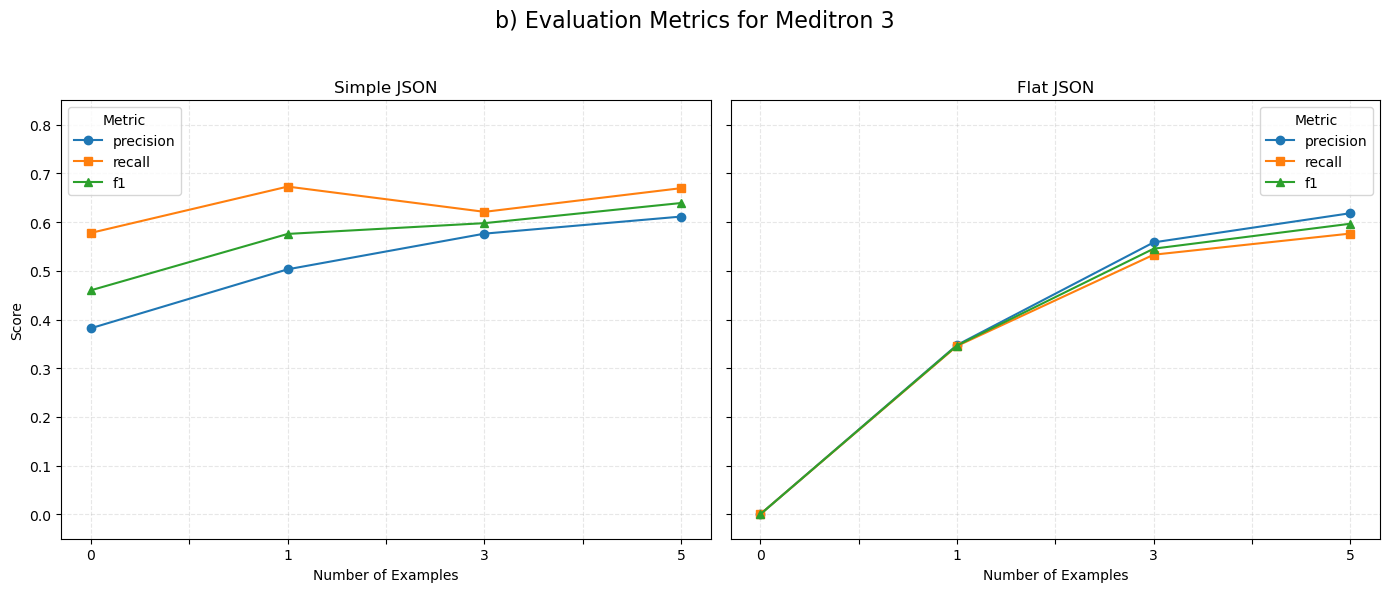

            prompt  precision    recall        f1     V/I/W  emissions   duration
0  deepseek-llm_10   0.008721  0.004878  0.006257    0/8/42   0.000030   6.011786
1  deepseek-llm_11   0.233397  0.266811  0.248988    41/4/5   0.000035   6.805383
2  deepseek-llm_13   0.345161  0.463203  0.395564   38/2/10   0.000036   7.012800
3  deepseek-llm_15   0.358071  0.416847  0.385230   32/12/6   0.000042   8.183834
4  deepseek-llm_20   0.000000  0.000000  0.000000    0/6/44   0.000041   8.021792
5  deepseek-llm_21   0.205628  0.188492  0.196687    9/7/34   0.000005  15.883505
6  deepseek-llm_23   0.290179  0.250965  0.269151  14/12/24   0.000105  20.224856
7  deepseek-llm_25   0.100000  0.003150  0.006107    2/47/1   0.000084  16.392775


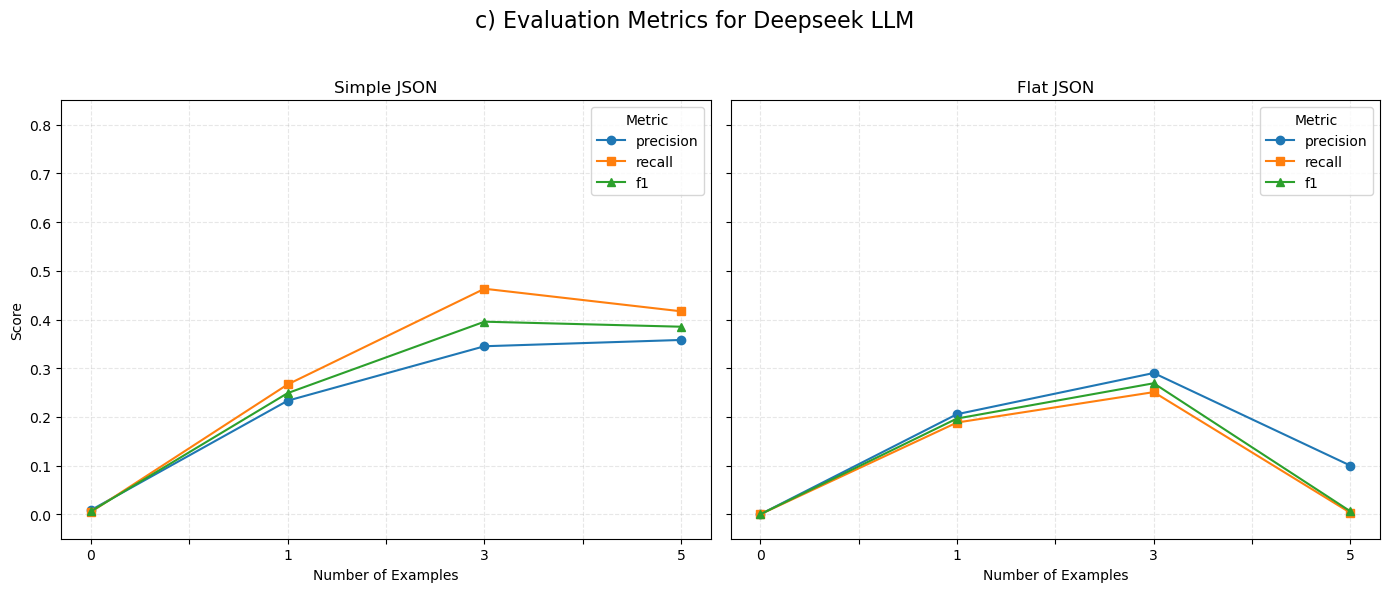

In [8]:
prompts1 = ["llama3_10", "llama3_11", "llama3_13", "llama3_15", "llama3_20", "llama3_21", "llama3_23", "llama3_25"]
prompts2 = ["meditron3_10", "meditron3_11", "meditron3_13", "meditron3_15", "meditron3_20", "meditron3_21", "meditron3_23", "meditron3_25"]
prompts3 = ["deepseek-llm_10", "deepseek-llm_11", "deepseek-llm_13", "deepseek-llm_15", "deepseek-llm_20", "deepseek-llm_21", "deepseek-llm_23", "deepseek-llm_25"]
all_prompt = [prompts1, prompts2, prompts3]

models = ["Llama 3", "Meditron 3", "Deepseek LLM", "a", "b", "c"]

for prompts in all_prompt:
    results = []
    for prompt in prompts:
        path = f"datasets/{prompt}"
        flat = prompt.endswith(("20", "21", "23", "25"))
        results.append(evaluate_and_collect(prompt, path, flat))
    plot_results(results, models[all_prompt.index(prompts)], models[all_prompt.index(prompts)+3])

# Batch size evaluation

      prompt  precision    recall        f1   V/I/W  emissions  duration  batch_size
0  llama3_13   0.725962  0.810376  0.765850  47/0/3   0.000036  7.903344           1
1  llama3_13   0.730185  0.756993  0.743348  47/0/3   0.000030  5.954778           2
2  llama3_13   0.699531  0.808318  0.750000  46/0/4   0.000033  6.465383           4
3  llama3_13   0.672052  0.738899  0.703892  47/1/2   0.000034  6.553824           8


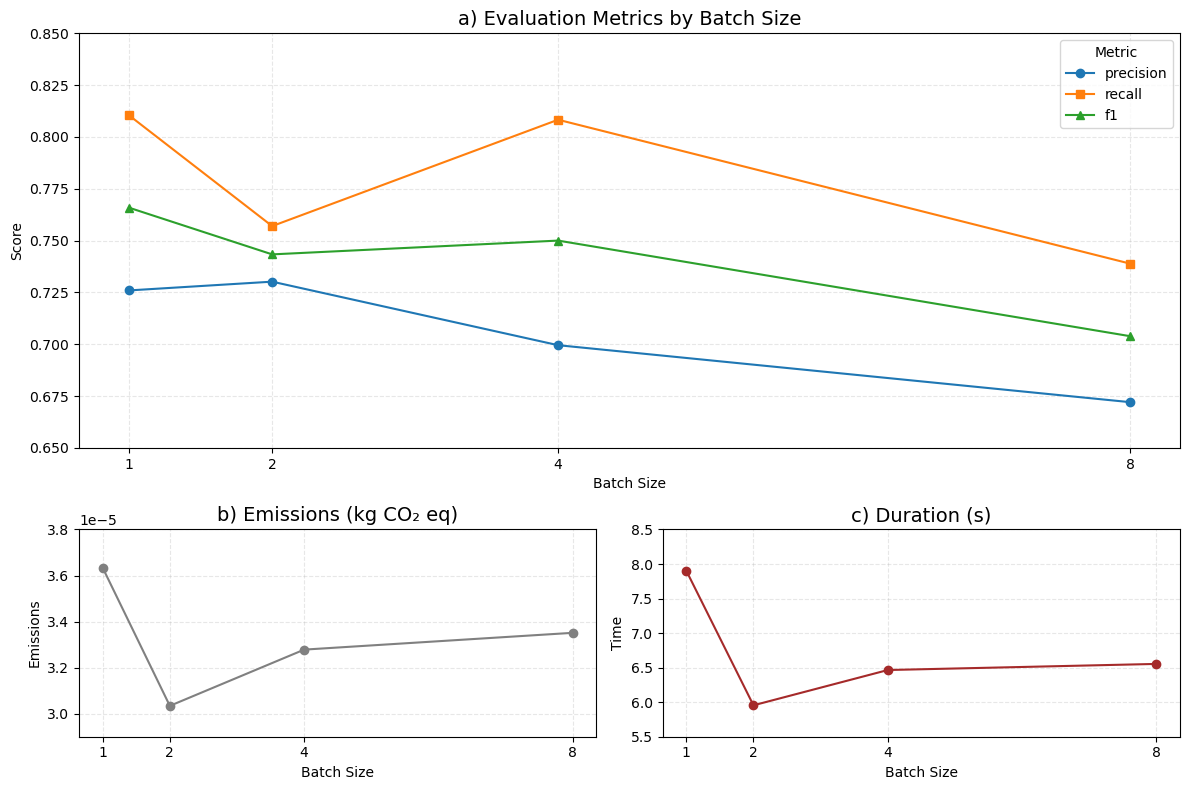

In [12]:
prompt = "llama3_13"
results = []
df = pd.read_csv("emissions_batch.csv")

for batch in [1, 2, 4, 8]:
    path = f"datasets/batch_size/{prompt}_batch_{batch}"
    result = evaluate_and_collect(prompt, path, False)
    row = df[df["batch_size"] == batch]
    batch_size = batch
    emissions = row.iloc[0]["emissions"] if not row.empty else result["emissions"]
    duration = row.iloc[0]["duration"] if not row.empty else result["duration"]
    result["batch_size"] = batch
    result["emissions"] = emissions 
    result["duration"] = duration  
    results.append(result)

results_df = pd.DataFrame(results)
results_df["emissions"] /= 50
results_df["duration"] /= 50
print(results_df)

# === Create a figure ===
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])  # 2 rows, 2 cols

# === Row 1: Performance metrics ===
ax_perf = fig.add_subplot(gs[0, :])
for metric, marker in zip(["precision", "recall", "f1"], ['o', 's', '^']):
    ax_perf.plot(results_df["batch_size"], results_df[metric], marker=marker, label=metric)

ax_perf.set_title("a) Evaluation Metrics by Batch Size", fontsize=14)
ax_perf.set_ylabel("Score")
ax_perf.set_ylim(0.65, 0.85) #ax_perf.set_ylim(0.0, 0.85)
ax_perf.set_xticks(results_df["batch_size"])
ax_perf.set_xlabel("Batch Size")
ax_perf.legend(title="Metric")
ax_perf.grid(True, linestyle='--', alpha=0.3)

# === Row 2, Col 1: Emissions ===
ax_emissions = fig.add_subplot(gs[1, 0])
ax_emissions.plot(results_df["batch_size"], results_df["emissions"], marker='o', color='gray')
ax_emissions.set_title("b) Emissions (kg CO₂ eq)", fontsize=14)
ax_emissions.set_xlabel("Batch Size")
ax_emissions.set_ylabel("Emissions")
ax_emissions.set_ylim(2.9e-5, 3.8e-5)
ax_emissions.set_xticks(results_df["batch_size"])
ax_emissions.grid(True, linestyle='--', alpha=0.3)


# === Row 2, Col 2: Duration ===
ax_duration = fig.add_subplot(gs[1, 1])
ax_duration.plot(results_df["batch_size"], results_df["duration"], marker='o', color='brown')
ax_duration.set_title("c) Duration (s)", fontsize=14)
ax_duration.set_xlabel("Batch Size")
ax_duration.set_ylabel("Time")
ax_duration.set_ylim(5.5, 8.5)
ax_duration.set_xticks(results_df["batch_size"])
ax_duration.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()



In [10]:
# === Check specific note and inference ===

note = 6
prompt = "llama3_10"

# === Load ground truth depending on prompt ===
if prompt.endswith(("21", "23", "25")):
    gt_path = "datasets/ground_truth_flat.json"
else:
    gt_path = "datasets/ground_truth.json"

with open(gt_path, 'r') as f:
    gt = json.load(f)

# === Lad outputs ===
preds = load_model_output(f"datasets/{prompt}.jsonl")

keys = ["Emergency Department", "Transfer", "Admission", "Discharge"]
for key in keys:
    pred_section = preds.get(note, {}).get("parsed_json", {})
    gt_section = gt[note-1]['extracted_data'].get(key)
    
    if pred_section and key in pred_section and pred_section[key] is not None:
        print(f"Prediction   [{key}]:", pred_section[key])
    else:
        print(f"Prediction   [{key}]: Not available")
    
    if gt_section is not None:
        print(f"Ground Truth [{key}]:", gt_section)
    else:
        print(f"Ground Truth [{key}]: Not available")

Prediction   [Emergency Department]: {'Body Temperature': 97.2, 'Systolic Blood Pressure': 84, 'Diastolic Blood Pressure': 136, 'Heart Rate': 16, 'Respiratory Rate': 100, 'Oxygen Saturation': 100}
Ground Truth [Emergency Department]: {'Body Temperature': 97.2, 'Systolic Blood Pressure': 136, 'Diastolic Blood Pressure': 85, 'Heart Rate': 84, 'Respiratory Rate': 16, 'Oxygen Saturation': 100}
Prediction   [Transfer]: Not available
Ground Truth [Transfer]: Not available
Prediction   [Admission]: {'Body Temperature': 97.9, 'Systolic Blood Pressure': 102, 'Diastolic Blood Pressure': 68, 'Heart Rate': 54, 'Respiratory Rate': 20, 'Oxygen Saturation': 96}
Ground Truth [Admission]: {'Body Temperature': 97.9, 'Systolic Blood Pressure': 102, 'Diastolic Blood Pressure': 68, 'Heart Rate': 54, 'Respiratory Rate': 20, 'Oxygen Saturation': 96}
Prediction   [Discharge]: {'Body Temperature': 98.4, 'Systolic Blood Pressure': 129, 'Diastolic Blood Pressure': 70, 'Heart Rate': 54, 'Respiratory Rate': 18, 'O